Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a TensorFlow Dataset from the ImageDataGenerator flow_from_directory output
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 9519 files belonging to 9 classes.
Using 7616 files for training.
Found 9519 files belonging to 9 classes.
Using 1903 files for validation.


In [ ]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary to store one instance of each class
one_instance_per_class = {}
# Iterate over the dataset to extract one instance of each class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[np.argmax(label.numpy())]  # Get the class name from the label
        if class_name not in one_instance_per_class:
            one_instance_per_class[class_name] = image
            break

# Visualize one instance of each class
plt.figure(figsize=(10, 6))
for i, (class_name, image) in enumerate(one_instance_per_class.items(), 1):
    plt.subplot(3, 3, i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
# Set up AUTOTUNE for buffer size
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Apply caching and prefetching to the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from tensorflow.keras import layers, models
num_classes = 9  # Assuming there are 9 classes in your dataset

# Define the data preprocessing pipeline
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),  # Normalize pixel values between 0 and 1
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

# Create the CNN model
model = models.Sequential([
    data_augmentation,  # Apply data augmentation to the input images
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.build(input_shape=(None, img_height, img_width, 3))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)      

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# We can see in the above graph, that with more epochs the model has started to overfit. Training accuracy
# is almost touching 1 with more epochs while validation accuracy has almost hit plateau. In loss graph, training loss
# has decreased significantly, and validation loss has reached a stable value.


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Define data augmentation parameters
from tensorflow.keras import layers, models
num_classes = 9  # Assuming there are 9 classes in your dataset

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.Rescaling(1./255),  # Normalize pixel values between 0 and 1
])


### Todo:
### Create the model, compile and train the model


In [ ]:

# Create the CNN model
model = models.Sequential([
    data_augmentation,  # Apply data augmentation to the input images
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.build(input_shape=(None, img_height, img_width, 3))


### Compiling the model

In [ ]:
## Your code goes here

### Todo, choose an appropirate optimiser and loss function

model.build(input_shape=(None, img_height, img_width, 3))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

### Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 41ms/step - loss: 1.9606 - accuracy: 0.2891 - val_loss: 1.9850 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.7041 - accuracy: 0.3962 - val_loss: 1.6750 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.5153 - accuracy: 0.4665 - val_loss: 1.4518 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.4210 - accuracy: 0.4950 - val_loss: 1.4438 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4489 - accuracy: 0.4944 - val_loss: 1.4321 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3900 - accuracy: 0.4994 - val_loss: 1.4143 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3416 - accuracy: 0.5151 - val_loss: 1.3657 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results

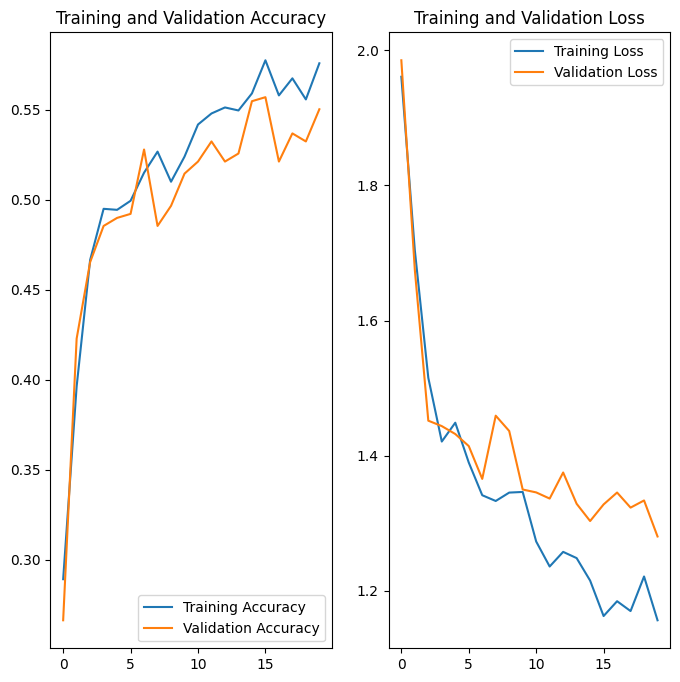

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

yes there is improvement in the model, as the validation accuracy is increasing.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

class_count = {class_name: 0 for class_name in class_names}
# Verify the contents of class_names and class_count for debugging
print("Class Names:", class_names)
print("Initial Class Count:", class_count)

# Count the number of images per class in the training dataset
for images, labels in train_ds:
    for label in labels:
        class_name = class_names[np.argmax(label.numpy())]  # Get the class name from the one-hot encoded label
        class_count[class_name] += 1

# Print the distribution of classes in the training dataset
print("Class Distribution in Training Dataset:")
for class_name, count in class_count.items():
    print(f"{class_name}: {count} images")

# Optionally, you can calculate the class imbalance ratio or percentage
total_samples = sum(class_count.values())
class_imbalance_ratio = {class_name: count / total_samples for class_name, count in class_count.items()}
class_imbalance_percentage = {class_name: (count / total_samples) * 100 for class_name, count in class_count.items()}

# Print the class imbalance ratio and percentage
print("\nClass Imbalance Ratio:")
for class_name, ratio in class_imbalance_ratio.items():
    print(f"{class_name}: {ratio:.4f}")

print("\nClass Imbalance Percentage:")
for class_name, percentage in class_imbalance_percentage.items():
    print(f"{class_name}: {percentage:.2f}%")


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import os
import Augmentor

# Specify the base directory where the class directories are located
base_dir = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Verify that the base directory exists
if not os.path.exists(base_dir):
    print("Error: Base directory does not exist.")
    # Handle the error or exit the script

# Loop through each class and apply augmentation
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)  # Construct the full path to the class directory
    if not os.path.exists(class_dir):
        print(f"Warning: Class directory '{class_dir}' does not exist.")
        continue  # Skip this class if the directory does not exist

    p = Augmentor.Pipeline(class_dir)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A1E44E47F70>: 100%|██████████| 500/500 [00:26<00:00, 18.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A1E44E63F70>: 100%|██████████| 500/500 [00:25<00:00, 19.81 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A1E46290850>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A1E45029390>: 100%|██████████| 500/500 [01:55<00:00,  4.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2155x1958 at 0x7A1E46D1FFA0>: 100%|██████████| 500/500 [01:44<00:00,  4.80 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A1E44EF6B90>: 100%|██████████| 500/500 [00:24<00:00, 20.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A1E44FA8DC0>: 100%|██████████| 500/500 [00:45<00:00, 11.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A1E44F77550>: 100%|██████████| 500/500 [00:21<00:00, 23.02 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A1E44EF7610>: 100%|██████████| 500/500 [00:22<00:00, 21.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7280


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import os
from glob import glob  # Import the glob function from the glob module
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_085662d6-3fc9-4d9e-8cef-5f5102a95c8c.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010977.jpg_99261d84-37b7-451e-9a43-853a2ca03113.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010866.jpg_afe262f7-1080-41cb-a070-cfce585c145b.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010791.jpg_de7d9e75-7fca-4c88-a97b-7d3e3f5b4d43.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000487.jpg_db7858a9-1823-4a01-b9c4-ea6679230750.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
dataframe_dict_new

{'/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010767.jpg_085662d6-3fc9-4d9e-8cef-5f5102a95c8c.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010977.jpg_99261d84-37b7-451e-9a43-853a2ca03113.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010866.jpg_afe262f7-1080-41cb-a070-cfce585c145b.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010791.jpg_de7d9e75-7fca-4c88-a97b-7d3e3f5b4d43.jpg': 'melanoma',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000487.jpg_db7858a9-1823-4a01-b9c4-ea6679230750.jpg': 'melanoma',


In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

AttributeError: '_PrefetchDataset' object has no attribute 'append'

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a TensorFlow Dataset from the ImageDataGenerator flow_from_directory output
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=123
)



Found 9519 files belonging to 9 classes.
Using 7616 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=123
)


Found 9519 files belonging to 9 classes.
Using 1903 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
from tensorflow.keras import layers, models
num_classes = 9  # Assuming there are 9 classes in your dataset

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.Rescaling(1./255),  # Normalize pixel values between 0 and 1
])


# Create the CNN model
model = models.Sequential([
    data_augmentation,  # Apply data augmentation to the input images
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

model.build(input_shape=(None, img_height, img_width, 3))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.build(input_shape=(None, img_height, img_width, 3))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:

## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
238/238 [==============================] - 765s 3s/step - loss: 1.8181 - accuracy: 0.3095 - val_loss: 1.6193 - val_accuracy: 0.3715
Epoch 2/50
238/238 [==============================] - 665s 3s/step - loss: 1.5351 - accuracy: 0.4303 - val_loss: 1.4097 - val_accuracy: 0.4619
Epoch 3/50
238/238 [==============================] - 662s 3s/step - loss: 1.4288 - accuracy: 0.4710 - val_loss: 1.4050 - val_accuracy: 0.4719
Epoch 4/50
238/238 [==============================] - 676s 3s/step - loss: 1.3544 - accuracy: 0.4915 - val_loss: 1.2873 - val_accuracy: 0.5160
Epoch 5/50
238/238 [==============================] - 672s 3s/step - loss: 1.2925 - accuracy: 0.5175 - val_loss: 1.2596 - val_accuracy: 0.5318
Epoch 6/50
 36/238 [===>..........................] - ETA: 8:40 - loss: 1.2942 - accuracy: 0.5122

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
# Yes the class rebalance helped.
# We got rid of overfitting by using Augmenatation technioque. Results are better on validaiton dataset now.